# MSADS509 Final Project Modeling

In [71]:
import datetime
import random
import time
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os
import re
import spacy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics import accuracy_score, classification_report

from scipy.sparse import hstack

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from pandas import json_normalize

nlp = spacy.load('en_core_web_sm')

from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /Users/kevinbaum/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kevinbaum/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Load data from Data folder

In [72]:
# make sure your directory is the same one that was used to store the cleaned dataframe
df = pd.read_csv('Data/cleaned.csv')

def clean_tokens(tokens):
    return [token.strip("[]'") for token in tokens.split(', ')]

df['tokens'] = df['tokens'].apply(clean_tokens)
df

,source,url,content,tokens
0,cnn,https://www.cnn.com/2024/02/12/politics/cq-bro...,Chairman of the Joint Chiefs of Staff Gen. CQ ...,"[chairman, joint, chiefs, staff, gen, cq, brow..."
1,cnn,https://www.cnn.com/2024/02/12/politics/trump-...,Trump has endorsed North Carolina Republican P...,"[trump, endorsed, north, carolina, republican,..."
2,cnn,https://www.cnn.com/2024/02/12/politics/senate...,The Senate is inching closer to final passage ...,"[senate, inching, closer, final, passage, 953,..."
3,cnn,https://www.cnn.com/2024/02/12/politics/bidens...,Biden and King Abdullah II of Jordan met Monda...,"[biden, king, abdullah, ii, jordan, met, monda..."
4,cnn,https://www.cnn.com/2024/02/12/politics/trump-...,Trump on Monday asked the SupremeCourt to step...,"[trump, monday, asked, supremecourt, step, cha..."
...,...,...,...,...
235,foxnews,https://www.foxnews.com/politics/house-republi...,Rep. Ronny Jackson demands Biden take cognitiv...,"[rep, ronny, jackson, demands, biden, take, co..."
236,foxnews,https://www.foxnews.com/politics/gop-senators-...,Biden and the Democrat just do not care: Sen. ...,"[biden, democrat, care, sen, ted, cruz, sen, t..."
237,foxnews,https://www.foxnews.com/politics/doj-defends-s...,Former US attorney discusses Special Counsel H...,"[us, attorney, discusses, special, counsel, hu..."
238,foxnews,https://www.foxnews.com/politics/fox-news-poli...,Welcome to Fox News’ Politics newsletter with ...,"[welcome, news’, politics, newsletter, latest,..."


## EDA for tokens

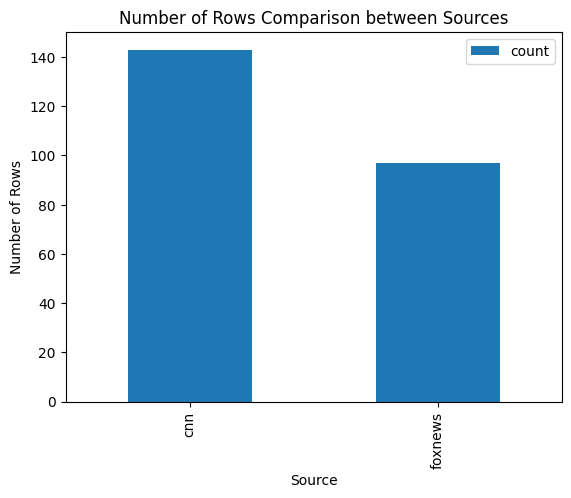

In [73]:
# Count the number of rows for each source
source_counts = df['source'].value_counts()

source_counts.plot(kind='bar', legend=True)
plt.xlabel('Source')
plt.ylabel('Number of Rows')
plt.title('Number of Rows Comparison between Sources')
plt.show()

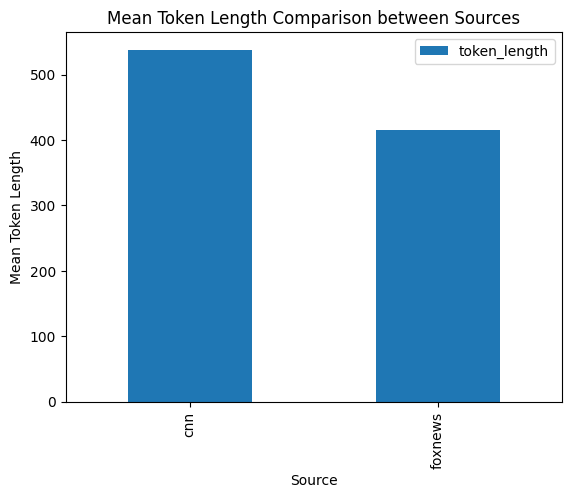

In [74]:
# the length of tokens for each article
df['token_length'] = df['tokens'].apply(lambda x: len(x))

source_token_length = df.groupby('source')['token_length'].mean()

source_token_length.plot(kind='bar', legend=True)
plt.xlabel('Source')
plt.ylabel('Mean Token Length')
plt.title('Mean Token Length Comparison between Sources')
plt.show()

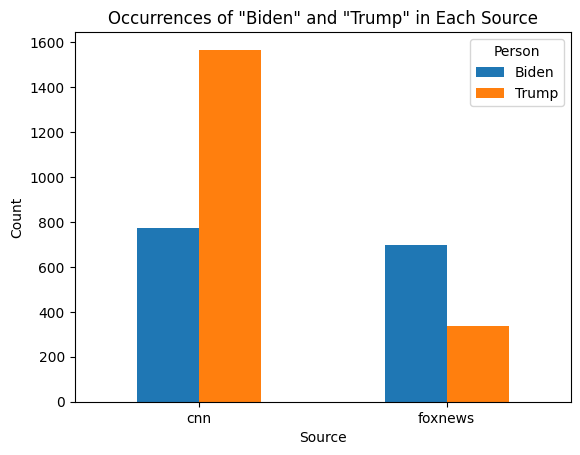

In [75]:
# count occurrences of a word in a list
def count_occurrences(tokens, word):
    return sum(1 for token in tokens if re.search(r'\b{}\b'.format(word), token, flags=re.IGNORECASE))

biden_counts = df.groupby('source')['tokens'].apply(lambda x: sum(count_occurrences(tokens, 'biden') for tokens in x))
trump_counts = df.groupby('source')['tokens'].apply(lambda x: sum(count_occurrences(tokens, 'trump') for tokens in x))

counts_df = pd.DataFrame({'Biden': biden_counts, 'Trump': trump_counts})

counts_df.plot(kind='bar')
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Occurrences of "Biden" and "Trump" in Each Source')
plt.xticks(rotation=0)
plt.legend(title='Person')
plt.show()

## WordCloud for each Source

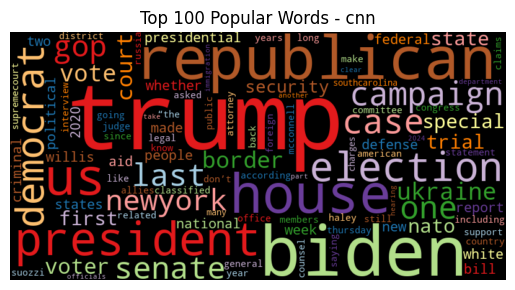

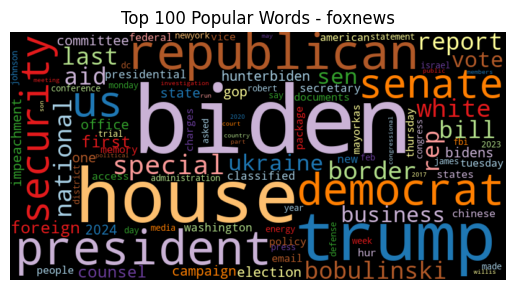

In [76]:

def wordcloud(df, title=None, max_words=100, stopwords=None):
    unique_sources = df['source'].unique()
    for source in unique_sources:
        tokens = df[df['source'] == source]['tokens']
        all_tokens = [token for sublist in tokens for token in sublist]
        counter = Counter(all_tokens)

        # Filter stop words in frequency counter
        if stopwords is not None:
            counter = {token: freq for (token, freq) in counter.items() if token not in stopwords}

        wc = WordCloud(width=800, height=400,
                       background_color="black", colormap="Paired",
                       max_font_size=150, max_words=max_words)
        wc.generate_from_frequencies(counter)
        
        plt.title(f"{title} - {source}")
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()

wordcloud(df, title="Top 100 Popular Words")


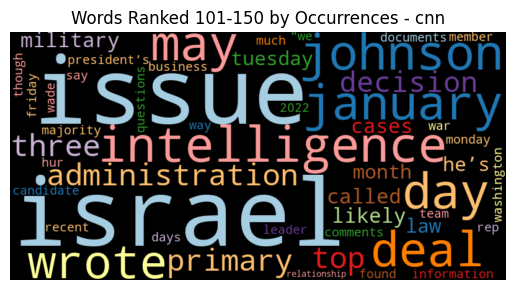

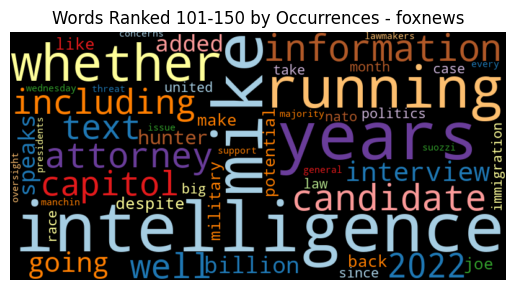

In [77]:

def wordcloud(df, title=None, max_words=200, stopwords=None):
    unique_sources = df['source'].unique()
    for source in unique_sources:
        tokens = df[df['source'] == source]['tokens']
        all_tokens = [token for sublist in tokens for token in sublist]
        counter = Counter(all_tokens)

        # Filter stop words in frequency counter
        if stopwords is not None:
            counter = {token: freq for (token, freq) in counter.items() if token not in stopwords}

        # Sort the counter by frequency and get the words ranked from 101st to 150th
        sorted_counter = dict(counter.most_common())
        words_101_to_150 = dict(list(sorted_counter.items())[100:150])

        wc = WordCloud(width=800, height=400,
                       background_color="black", colormap="Paired",
                       max_font_size=150, max_words=max_words)
        wc.generate_from_frequencies(words_101_to_150)
        
        plt.title(f"{title} - {source}")
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()

wordcloud(df, title="Words Ranked 101-150 by Occurrences")


## Modeling and Model Evaluations

## Topic Modeling

In [78]:
sw = stopwords.words("english")
punctuation = set(punctuation) # speeds up comparison
extra_sw = ['cnn', 'fox', 'news', 'said', '-', '-', '--', '—','told', 'would', 'read', 'get', 'could', 
            'also', "it's", 'think', 'time', 'even', 'former', 'party', 'i', '“i', "she's", 'says', 
            'images', 'getty', 'im', 'this', 'we', 'it', 'digital', 'the', 'that', 'story', 'doesn']
sw.extend(extra_sw)

In [79]:
# define the topic displaying function
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [80]:
# create separate dataframes for the two news sources
cnn_df = df[df['source'] == 'cnn']
fox_df = df[df['source'] == 'foxnews']

# define the function to join tokens back into a string
def join_tokens(tokens):
    return ' '.join(tokens)

# Apply the join_tokens function to the "tokens" column
cnn_df["tokens_str"] = cnn_df["tokens"].apply(join_tokens)
fox_df["tokens_str"] = fox_df["tokens"].apply(join_tokens)

In [81]:
cnn_df

,source,url,content,tokens,token_length,tokens_str
0,cnn,https://www.cnn.com/2024/02/12/politics/cq-bro...,Chairman of the Joint Chiefs of Staff Gen. CQ ...,"[chairman, joint, chiefs, staff, gen, cq, brow...",469,chairman joint chiefs staff gen cq brown monda...
1,cnn,https://www.cnn.com/2024/02/12/politics/trump-...,Trump has endorsed North Carolina Republican P...,"[trump, endorsed, north, carolina, republican,...",104,trump endorsed north carolina republican chair...
2,cnn,https://www.cnn.com/2024/02/12/politics/senate...,The Senate is inching closer to final passage ...,"[senate, inching, closer, final, passage, 953,...",399,senate inching closer final passage 953 billio...
3,cnn,https://www.cnn.com/2024/02/12/politics/bidens...,Biden and King Abdullah II of Jordan met Monda...,"[biden, king, abdullah, ii, jordan, met, monda...",642,biden king abdullah ii jordan met monday aimin...
4,cnn,https://www.cnn.com/2024/02/12/politics/trump-...,Trump on Monday asked the SupremeCourt to step...,"[trump, monday, asked, supremecourt, step, cha...",567,trump monday asked supremecourt step charged d...
...,...,...,...,...,...,...
220,cnn,https://www.cnn.com/2024/02/15/politics/navy-f...,Members of Congress pressed the CEO of the nat...,"[members, congress, pressed, ceo, nation’s, la...",512,members congress pressed ceo nation’s largest ...
221,cnn,https://www.cnn.com/2024/02/16/politics/kamala...,US Vice President Kamala Harris on Friday call...,"[us, vice, president, kamala, harris, friday, ...",565,us vice president kamala harris friday called ...
222,cnn,https://www.cnn.com/2024/01/30/politics/trump-...,NewYork state Judge Arthur Engoron has the fut...,"[newyork, state, judge, arthur, engoron, futur...",583,newyork state judge arthur engoron future trum...
223,cnn,https://www.cnn.com/2024/02/15/politics/border...,The acting deputy chief of the US Border Patro...,"[acting, deputy, chief, us, border, patrol, jo...",101,acting deputy chief us border patrol joel mart...


In [82]:
fox_df

,source,url,content,tokens,token_length,tokens_str
47,foxnews,https://www.foxnews.com/politics/biden-takes-j...,Biden takes jab at special counsel report with...,"[biden, takes, jab, special, counsel, report, ...",473,biden takes jab special counsel report joke me...
48,foxnews,https://www.foxnews.com/politics/rfk-jr-apolog...,RFK Jr. drops surprise campaign ad during Supe...,"[rfk, jr, drops, surprise, campaign, ad, super...",323,rfk jr drops surprise campaign ad super bowl a...
49,foxnews,https://www.foxnews.com/politics/bidens-upcomi...,Biden won't take cognitive test in physical ex...,"[biden, wont, take, cognitive, test, physical,...",228,biden wont take cognitive test physical exam w...
50,foxnews,https://www.foxnews.com/politics/kamala-harris...,Marc Thiessen questions whether Biden is capab...,"[marc, thiessen, questions, whether, biden, ca...",274,marc thiessen questions whether biden capable ...
51,foxnews,https://www.foxnews.com/politics/climate-activ...,Biden export suspension on liquefied natural g...,"[biden, export, suspension, liquefied, natural...",451,biden export suspension liquefied natural gas ...
...,...,...,...,...,...,...
235,foxnews,https://www.foxnews.com/politics/house-republi...,Rep. Ronny Jackson demands Biden take cognitiv...,"[rep, ronny, jackson, demands, biden, take, co...",464,rep ronny jackson demands biden take cognitive...
236,foxnews,https://www.foxnews.com/politics/gop-senators-...,Biden and the Democrat just do not care: Sen. ...,"[biden, democrat, care, sen, ted, cruz, sen, t...",325,biden democrat care sen ted cruz sen ted cruz ...
237,foxnews,https://www.foxnews.com/politics/doj-defends-s...,Former US attorney discusses Special Counsel H...,"[us, attorney, discusses, special, counsel, hu...",382,us attorney discusses special counsel hurs app...
238,foxnews,https://www.foxnews.com/politics/fox-news-poli...,Welcome to Fox News’ Politics newsletter with ...,"[welcome, news’, politics, newsletter, latest,...",139,welcome news’ politics newsletter latest polit...


In [83]:
# create our count text vectorizers 
cnn_count_text_vectorizer = CountVectorizer(stop_words=list(sw), min_df=3, max_df=0.7)
cnn_count_text_vectors = cnn_count_text_vectorizer.fit_transform(cnn_df["tokens_str"])
print(cnn_count_text_vectors.shape)

fox_count_text_vectorizer = CountVectorizer(stop_words=list(sw), min_df=3, max_df=0.7)
fox_count_text_vectors = fox_count_text_vectorizer.fit_transform(fox_df["tokens_str"])
print(fox_count_text_vectors.shape)

(143, 3695)
(97, 2363)


In [84]:
# create our tf-idf text vectorizers 
cnn_tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(sw), min_df=3, max_df=0.7)
cnn_tfidf_text_vectors = cnn_tfidf_text_vectorizer.fit_transform(cnn_df['tokens_str'])
print(cnn_tfidf_text_vectors.shape)

fox_tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(sw), min_df=3, max_df=0.7)
fox_tfidf_text_vectors = fox_tfidf_text_vectorizer.fit_transform(fox_df['tokens_str'])
print(fox_tfidf_text_vectors.shape)

(143, 3695)
(97, 2363)


### Fitting a Non-Negative Matrix Factorization Model

#### 5 Topics

In [85]:
# fit our NMF models
cnn_nmf_model = NMF(n_components=5, random_state=314)
cnn_W_nmf_matrix = cnn_nmf_model.fit_transform(cnn_tfidf_text_vectors)
cnn_H_nmf_matrix = cnn_nmf_model.components_

fox_nmf_model = NMF(n_components=5, random_state=315)
fox_W_nmf_matrix = fox_nmf_model.fit_transform(fox_tfidf_text_vectors)
fox_H_nmf_matrix = fox_nmf_model.components_

In [86]:
# assertion statements to ensure the document-topic and topic-feature matrices have the intended shapes
assert cnn_W_nmf_matrix.shape == (143, 5), f"Expected shape (143, 5), but got {cnn_W_nmf_matrix.shape}"
assert cnn_H_nmf_matrix.shape == (5, 3695), f"Expected shape (5, 3695), but got {cnn_H_nmf_matrix.shape}"
assert fox_W_nmf_matrix.shape == (97, 5), f"Expected shape (97, 5), but got {fox_W_nmf_matrix.shape}"
assert fox_H_nmf_matrix.shape == (5, 2363), f"Expected shape (5, 2363), but got {fox_H_nmf_matrix.shape}"

In [87]:
display_topics(cnn_nmf_model, cnn_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  trump (2.40)
  case (1.01)
  trial (0.86)
  willis (0.86)
  court (0.79)

Topic 01
  bill (1.53)
  aid (1.52)
  ukraine (1.51)
  senate (1.44)
  border (1.40)

Topic 02
  biden (1.82)
  hur (1.69)
  report (1.22)
  classified (1.11)
  documents (0.94)

Topic 03
  suozzi (1.99)
  democrat (1.29)
  pilip (0.99)
  santos (0.96)
  republican (0.84)

Topic 04
  nato (2.03)
  trump (1.57)
  us (0.88)
  russia (0.74)
  biden (0.63)


In [88]:
display_topics(fox_nmf_model, fox_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  aid (1.19)
  senate (1.03)
  border (1.03)
  bill (0.97)
  package (0.92)

Topic 01
  bobulinski (3.24)
  hunterbiden (2.35)
  2017 (1.10)
  business (1.07)
  hunter (1.05)

Topic 02
  hur (1.31)
  report (1.19)
  special (1.17)
  counsel (1.09)
  classified (1.03)

Topic 03
  trump (2.50)
  election (0.88)
  haley (0.70)
  republican (0.69)
  suozzi (0.67)

Topic 04
  manchin (5.36)
  romney (3.47)
  sen (2.41)
  mitt (2.36)
  running (2.18)


In [89]:
cnn_W_nmf_matrix.sum(axis=0)/cnn_W_nmf_matrix.sum()*100.0

array([18.83568536, 21.55767503, 19.84341513, 17.61373797, 22.14948651])

In [90]:
fox_W_nmf_matrix.sum(axis=0)/fox_W_nmf_matrix.sum()*100.0

array([20.55896756, 17.3733471 , 25.82227589, 26.73961564,  9.50579381])

#### 4 Topics

In [91]:
# fit our NMF models 4
cnn_nmf_model4 = NMF(n_components=4, random_state=314)
cnn_W_nmf_matrix4 = cnn_nmf_model4.fit_transform(cnn_tfidf_text_vectors)
cnn_H_nmf_matrix4 = cnn_nmf_model4.components_

fox_nmf_model4 = NMF(n_components=4, random_state=315)
fox_W_nmf_matrix4 = fox_nmf_model4.fit_transform(fox_tfidf_text_vectors)
fox_H_nmf_matrix4 = fox_nmf_model4.components_

In [92]:
display_topics(cnn_nmf_model4, cnn_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  trump (2.49)
  case (0.86)
  trial (0.73)
  willis (0.70)
  election (0.69)

Topic 01
  ukraine (1.39)
  aid (1.24)
  bill (1.23)
  senate (1.14)
  border (1.10)

Topic 02
  biden (1.72)
  hur (1.38)
  report (1.02)
  classified (0.91)
  documents (0.76)

Topic 03
  suozzi (1.99)
  democrat (1.28)
  pilip (0.99)
  santos (0.96)
  republican (0.86)


In [93]:
display_topics(fox_nmf_model4, fox_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  aid (1.18)
  senate (1.03)
  border (1.02)
  bill (0.96)
  package (0.91)

Topic 01
  bobulinski (3.23)
  hunterbiden (2.35)
  2017 (1.10)
  business (1.07)
  hunter (1.05)

Topic 02
  hur (1.31)
  report (1.19)
  special (1.17)
  counsel (1.09)
  classified (1.04)

Topic 03
  trump (2.34)
  election (0.82)
  republican (0.68)
  haley (0.66)
  suozzi (0.61)


In [94]:
cnn_W_nmf_matrix4.sum(axis=0)/cnn_W_nmf_matrix4.sum()*100.0

array([25.64844998, 28.67559657, 25.32015688, 20.35579657])

In [95]:
fox_W_nmf_matrix4.sum(axis=0)/fox_W_nmf_matrix4.sum()*100.0

array([22.58918529, 18.70581594, 27.65188173, 31.05311704])

### Fitting an LSA Model

#### 5 Topics

In [96]:
# fit our LSA models
cnn_svd_model = TruncatedSVD(n_components=5, random_state=320)
cnn_W_svd_matrix = cnn_svd_model.fit_transform(cnn_tfidf_text_vectors)
cnn_H_svd_matrix = cnn_svd_model.components_

fox_svd_model = TruncatedSVD(n_components=5, random_state=321)
fox_W_svd_matrix = fox_svd_model.fit_transform(fox_tfidf_text_vectors)
fox_H_svd_matrix = fox_svd_model.components_

In [97]:
# assertion statements to ensure the document-topic and topic-feature matrices have the intended shapes
assert cnn_W_svd_matrix.shape == (143, 5), f"Expected shape (143, 5), but got {cnn_W_svd_matrix.shape}"
assert cnn_H_svd_matrix.shape == (5, 3695), f"Expected shape (5, 3695), but got {cnn_H_svd_matrix.shape}"
assert fox_W_svd_matrix.shape == (97, 5), f"Expected shape (97, 5), but got {fox_W_svd_matrix.shape}"
assert fox_H_svd_matrix.shape == (5, 2363), f"Expected shape (5, 2363), but got {fox_H_svd_matrix.shape}"

In [98]:
display_topics(cnn_svd_model, cnn_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  trump (1.31)
  biden (0.58)
  republican (0.45)
  election (0.40)
  case (0.34)

Topic 01
  ukraine (6.30)
  aid (5.76)
  bill (5.68)
  senate (5.50)
  border (5.25)

Topic 02
  biden (5.55)
  hur (5.28)
  report (3.76)
  classified (3.44)
  documents (2.90)

Topic 03
  suozzi (16.62)
  democrat (9.45)
  pilip (8.20)
  santos (7.99)
  newyork (6.37)

Topic 04
  nato (24.78)
  haley (11.60)
  trump (10.63)
  suozzi (9.25)
  biden (8.63)


In [99]:
display_topics(fox_svd_model, fox_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  trump (0.78)
  republican (0.46)
  special (0.39)
  senate (0.39)
  border (0.37)

Topic 01
  bobulinski (19.09)
  hunterbiden (14.55)
  business (6.85)
  2017 (6.79)
  hunter (6.55)

Topic 02
  hur (16.67)
  special (15.21)
  report (14.67)
  counsel (14.02)
  classified (13.41)

Topic 03
  trump (46.93)
  election (16.40)
  haley (16.33)
  willis (13.47)
  newyork (13.04)

Topic 04
  manchin (14.81)
  romney (9.61)
  sen (6.66)
  mitt (6.53)
  running (5.92)


In [100]:
cnn_W_svd_matrix.sum(axis=0)/cnn_W_svd_matrix.sum()*100.0

array([86.27215675,  6.2283855 ,  6.9115943 , -0.11539489,  0.70325833])

In [101]:
fox_W_svd_matrix.sum(axis=0)/fox_W_svd_matrix.sum()*100.0

array([90.21771346,  3.75501037, -0.76965611,  0.90394909,  5.8929832 ])

#### 4 Topics

In [102]:
# fit our LSA models 4
cnn_svd_model4 = TruncatedSVD(n_components=4, random_state=320)
cnn_W_svd_matrix4 = cnn_svd_model4.fit_transform(cnn_tfidf_text_vectors)
cnn_H_svd_matrix4 = cnn_svd_model4.components_

fox_svd_model4 = TruncatedSVD(n_components=4, random_state=321)
fox_W_svd_matrix4 = fox_svd_model4.fit_transform(fox_tfidf_text_vectors)
fox_H_svd_matrix4 = fox_svd_model4.components_

In [103]:
display_topics(cnn_svd_model4, cnn_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  trump (1.31)
  biden (0.58)
  republican (0.45)
  election (0.40)
  case (0.34)

Topic 01
  ukraine (6.31)
  aid (5.77)
  bill (5.69)
  senate (5.51)
  border (5.25)

Topic 02
  biden (5.55)
  hur (5.29)
  report (3.76)
  classified (3.45)
  documents (2.90)

Topic 03
  suozzi (16.11)
  democrat (9.15)
  pilip (7.95)
  santos (7.74)
  newyork (6.22)


In [104]:
display_topics(fox_svd_model4, fox_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  trump (0.78)
  republican (0.46)
  special (0.39)
  senate (0.39)
  border (0.37)

Topic 01
  bobulinski (19.36)
  hunterbiden (14.74)
  business (6.94)
  2017 (6.88)
  hunter (6.63)

Topic 02
  hur (16.63)
  special (15.14)
  report (14.61)
  counsel (13.99)
  classified (13.41)

Topic 03
  trump (48.32)
  election (16.77)
  haley (16.74)
  willis (14.04)
  newyork (13.50)


In [105]:
cnn_W_svd_matrix4.sum(axis=0)/cnn_W_svd_matrix4.sum()*100.0

array([ 8.68549898e+01,  6.26796756e+00,  6.96257431e+00, -8.55316871e-02])

In [106]:
fox_W_svd_matrix4.sum(axis=0)/fox_W_svd_matrix4.sum()*100.0

array([95.84248683,  3.98084627, -0.83215167,  1.00881857])

### Fitting an LDA Model

#### 5 Topics

In [107]:
# fit our LDA models
cnn_lda_model = LatentDirichletAllocation(n_components=5, random_state=40)
cnn_W_lda_matrix = cnn_lda_model.fit_transform(cnn_count_text_vectors)
cnn_H_lda_matrix = cnn_lda_model.components_

fox_lda_model = LatentDirichletAllocation(n_components=5, random_state=41)
fox_W_lda_matrix = fox_lda_model.fit_transform(fox_count_text_vectors)
fox_H_lda_matrix = fox_lda_model.components_

In [108]:
# assertion statements to ensure the document-topic and topic-feature matrices have the intended shapes
assert cnn_W_lda_matrix.shape == (143, 5), f"Expected shape (143, 5), but got {cnn_W_lda_matrix.shape}"
assert cnn_H_lda_matrix.shape == (5, 3695), f"Expected shape (5, 3695), but got {cnn_H_lda_matrix.shape}"
assert fox_W_lda_matrix.shape == (97, 5), f"Expected shape (97, 5), but got {fox_W_lda_matrix.shape}"
assert fox_H_lda_matrix.shape == (5, 2363), f"Expected shape (5, 2363), but got {fox_H_lda_matrix.shape}"

In [109]:
display_topics(cnn_lda_model, cnn_count_text_vectorizer.get_feature_names_out())


Topic 00
  democrat (2.27)
  republican (2.26)
  suozzi (1.43)
  vote (1.19)
  gop (1.14)

Topic 01
  biden (3.48)
  report (0.94)
  hur (0.89)
  republican (0.68)
  trump (0.65)

Topic 02
  willis (2.39)
  wade (1.49)
  trump (1.14)
  senate (1.10)
  democrat (1.03)

Topic 03
  trump (5.73)
  election (1.28)
  case (1.14)
  court (0.83)
  trial (0.73)

Topic 04
  us (1.57)
  ukraine (1.14)
  republican (1.08)
  aid (0.82)
  nato (0.82)


In [110]:
display_topics(fox_lda_model, fox_count_text_vectorizer.get_feature_names_out())


Topic 00
  report (1.63)
  special (1.61)
  hur (1.53)
  counsel (1.50)
  memory (1.30)

Topic 01
  security (1.03)
  trump (0.97)
  ukraine (0.81)
  national (0.80)
  willis (0.79)

Topic 02
  border (1.51)
  republican (1.36)
  senate (1.30)
  vote (0.95)
  mayorkas (0.83)

Topic 03
  bobulinski (1.62)
  hunterbiden (1.47)
  business (1.11)
  chinese (0.71)
  2017 (0.66)

Topic 04
  trump (2.90)
  republican (1.49)
  democrat (1.24)
  election (0.99)
  campaign (0.70)


In [111]:
# prepare our models for display
cnn_lda_display = pyLDAvis.lda_model.prepare(cnn_lda_model, cnn_count_text_vectors, cnn_count_text_vectorizer, sort_topics=False)
fox_lda_display = pyLDAvis.lda_model.prepare(fox_lda_model, fox_count_text_vectors, fox_count_text_vectorizer, sort_topics=False)

In [112]:
pyLDAvis.display(cnn_lda_display)

In [113]:
pyLDAvis.display(fox_lda_display)

#### 4 Topics

In [114]:
# fit our LDA models 4
cnn_lda_model4 = LatentDirichletAllocation(n_components=4, random_state=40)
cnn_W_lda_matrix4 = cnn_lda_model4.fit_transform(cnn_count_text_vectors)
cnn_H_lda_matrix4 = cnn_lda_model4.components_

fox_lda_model4 = LatentDirichletAllocation(n_components=4, random_state=41)
fox_W_lda_matrix4 = fox_lda_model4.fit_transform(fox_count_text_vectors)
fox_H_lda_matrix4 = fox_lda_model4.components_

In [115]:
display_topics(cnn_lda_model4, cnn_count_text_vectorizer.get_feature_names_out())


Topic 00
  republican (2.20)
  democrat (1.27)
  border (1.16)
  senate (1.05)
  gop (0.93)

Topic 01
  biden (2.65)
  us (1.09)
  report (0.69)
  hur (0.60)
  white (0.54)

Topic 02
  willis (2.27)
  wade (1.31)
  trump (1.18)
  case (1.03)
  relationship (0.85)

Topic 03
  trump (5.56)
  election (1.21)
  case (0.89)
  court (0.76)
  trial (0.63)


In [116]:
display_topics(fox_lda_model4, fox_count_text_vectorizer.get_feature_names_out())


Topic 00
  report (1.40)
  special (1.33)
  hur (1.18)
  counsel (1.16)
  memory (1.11)

Topic 01
  trump (2.42)
  republican (0.97)
  democrat (0.74)
  campaign (0.67)
  security (0.66)

Topic 02
  border (1.30)
  senate (1.26)
  republican (1.25)
  bill (1.01)
  aid (0.87)

Topic 03
  bobulinski (1.47)
  hunterbiden (1.30)
  business (1.00)
  chinese (0.70)
  fbi (0.62)


In [117]:
cnn_lda_display4 = pyLDAvis.lda_model.prepare(cnn_lda_model4, cnn_count_text_vectors, cnn_count_text_vectorizer, sort_topics=False)
fox_lda_display4 = pyLDAvis.lda_model.prepare(fox_lda_model4, fox_count_text_vectors, fox_count_text_vectorizer, sort_topics=False)

In [118]:
pyLDAvis.display(cnn_lda_display4)

In [119]:
pyLDAvis.display(fox_lda_display4)

## Sentiment Analysis

In [120]:
sid = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):

    text_str = ' '.join(text)
    return sid.polarity_scores(text_str)

# get sentiment scores for each news article
df['sentiment_scores'] = df['tokens'].apply(get_sentiment_scores)

# Extract compound sentiment scores (normalized score between -1 (most negative) and +1 (most positive))
df['compound_sentiment'] = df['sentiment_scores'].apply(lambda x: x['compound'])

threshold = 0.05

df['sentiment_label'] = df['compound_sentiment'].apply(lambda score: 'positive' if score > threshold else 'negative' if score < -threshold else 'neutral')

df.head()

,source,url,content,tokens,token_length,sentiment_scores,compound_sentiment,sentiment_label
0,cnn,https://www.cnn.com/2024/02/12/politics/cq-bro...,Chairman of the Joint Chiefs of Staff Gen. CQ ...,"[chairman, joint, chiefs, staff, gen, cq, brow...",469,"{'neg': 0.127, 'neu': 0.775, 'pos': 0.098, 'co...",-0.9595,negative
1,cnn,https://www.cnn.com/2024/02/12/politics/trump-...,Trump has endorsed North Carolina Republican P...,"[trump, endorsed, north, carolina, republican,...",104,"{'neg': 0.029, 'neu': 0.68, 'pos': 0.291, 'com...",0.9838,positive
2,cnn,https://www.cnn.com/2024/02/12/politics/senate...,The Senate is inching closer to final passage ...,"[senate, inching, closer, final, passage, 953,...",399,"{'neg': 0.105, 'neu': 0.721, 'pos': 0.174, 'co...",0.9872,positive
3,cnn,https://www.cnn.com/2024/02/12/politics/bidens...,Biden and King Abdullah II of Jordan met Monda...,"[biden, king, abdullah, ii, jordan, met, monda...",642,"{'neg': 0.148, 'neu': 0.766, 'pos': 0.086, 'co...",-0.9939,negative
4,cnn,https://www.cnn.com/2024/02/12/politics/trump-...,Trump on Monday asked the SupremeCourt to step...,"[trump, monday, asked, supremecourt, step, cha...",567,"{'neg': 0.168, 'neu': 0.761, 'pos': 0.071, 'co...",-0.9957,negative


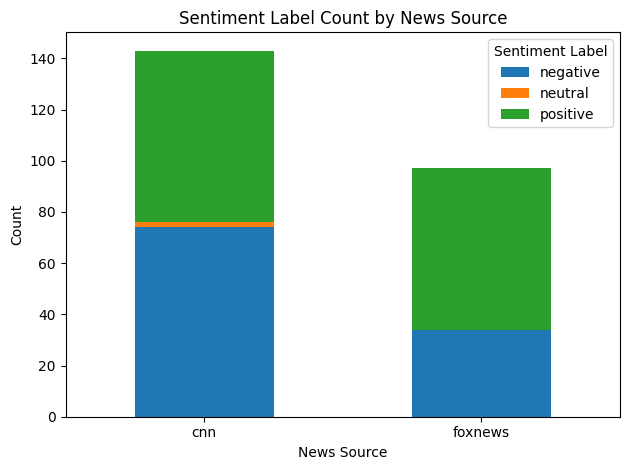

In [121]:
# Group by source and sentiment label and count occurrences
sentiment_counts = df.groupby(['source', 'sentiment_label']).size().unstack(fill_value=0)

sentiment_counts.plot(kind='bar', stacked=True)
plt.title('Sentiment Label Count by News Source')
plt.xlabel('News Source')
plt.ylabel('Count')
plt.xticks(rotation=0)  
plt.legend(title='Sentiment Label')
plt.tight_layout() 
plt.show()

## Binary Classification - Source Prediction

## Predicting News Sources with Random Forest Classifier

In [122]:

# Define X and y
X = df['tokens']  
y = df['source']  

# Convert list of tokens into strings and remove stop words
X_str = X.apply(lambda x: ' '.join([token for token in x if token.lower() not in sw]))

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X_str)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8333333333333334
Classification Report:
              precision    recall  f1-score   support

         cnn       0.76      1.00      0.87        26
     foxnews       1.00      0.64      0.78        22

    accuracy                           0.83        48
   macro avg       0.88      0.82      0.82        48
weighted avg       0.87      0.83      0.83        48



In [123]:

feature_importances = model.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

top_n = 20 
print(f"Top {top_n} features and their importances:")
for feature, importance in sorted_feature_importances[:top_n]:
    print(f"Feature: {feature}, Importance: {importance}")

Top 20 features and their importances:
Feature: the, Importance: 0.019457762723102442
Feature: we, Importance: 0.010278404387749384
Feature: please, Importance: 0.01020224845438076
Feature: biden, Importance: 0.0094910269548895
Feature: feb, Importance: 0.008807746745386077
Feature: dont, Importance: 0.008789921490812182
Feature: hill, Importance: 0.007784379245635765
Feature: content, Importance: 0.006711793845796507
Feature: dc, Importance: 0.0063161376667195445
Feature: 2024, Importance: 0.006175476550169621
Feature: latest, Importance: 0.005844767115020217
Feature: it, Importance: 0.0055366298045883555
Feature: valid, Importance: 0.005125129609628121
Feature: bidens, Importance: 0.004862530949031991
Feature: related, Importance: 0.004729150903611669
Feature: one, Importance: 0.004721953446508506
Feature: including, Importance: 0.004450905004907464
Feature: reporter, Importance: 0.004431897923624123
Feature: access, Importance: 0.00435665666819693
Feature: plus, Importance: 0.004098

## Clustering

Top words per cluster for CNN:
Cluster 0: nato, trump, biden, us, russia, ukraine, austin, intelligence, netanyahu, defense, 
Cluster 1: biden, hur, report, classified, fbi, documents, counsel, president, special, bobulinski, 
Cluster 2: trump, case, willis, trial, court, supremecourt, election, newyork, judge, wade, 
Cluster 3: trump, haley, kennedy, rnc, whatley, southcarolina, republican, biden, border, election, 
Cluster 4: senate, republican, border, aid, house, suozzi, bill, democrat, mcconnell, ukraine, 


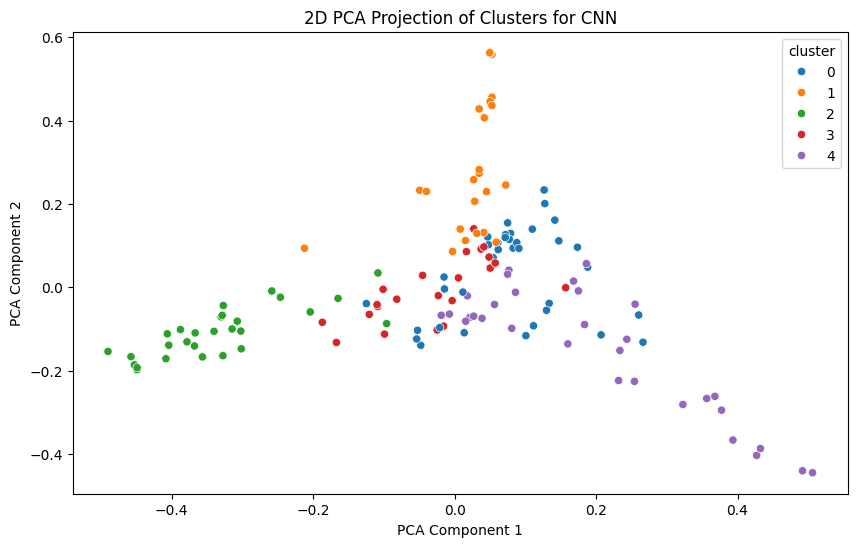

Top words per cluster for FoxNews:
Cluster 0: bobulinski, hunterbiden, biden, hunter, business, 2017, cefc, drug, cocaine, energy, 
Cluster 1: border, house, senate, aid, mayorkas, bill, johnson, package, security, republican, 
Cluster 2: biden, hur, president, special, report, counsel, classified, memory, documents, house, 
Cluster 3: hamas, israel, israeli, palestinian, oct, wray, sexual, hayes, twostate, solution, 
Cluster 4: trump, republican, manchin, election, willis, haley, democrat, ramaswamy, suozzi, campaign, 


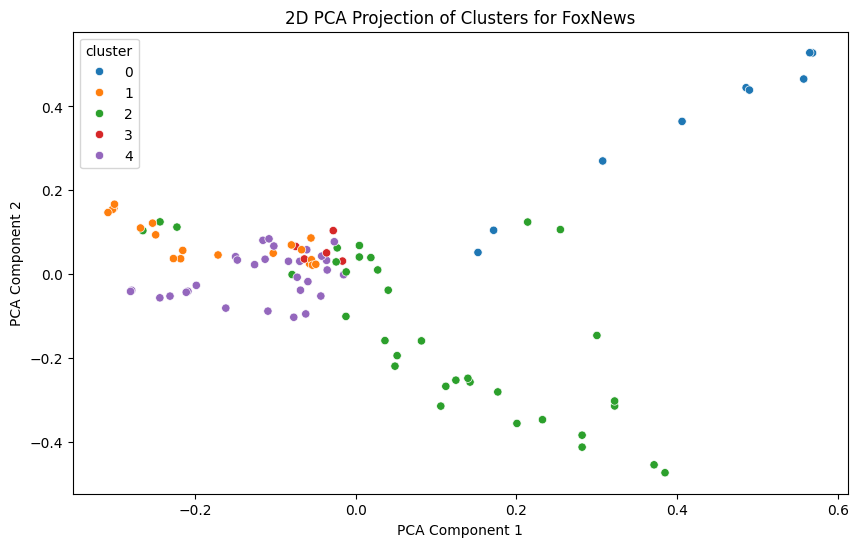

In [124]:

def cluster_and_plot(df, source_name):

    df['text'] = df['tokens'].apply(lambda x: ' '.join(x))
    tfidf_vectorizer = TfidfVectorizer()
    X_tfidf = tfidf_vectorizer.fit_transform(df['text'])

    # K-means clustering
    k = 5
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_tfidf)
    df['cluster'] = clusters

    # Print the top words per cluster
    print(f"Top words per cluster for {source_name}:")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    for i in range(k):
        print(f"Cluster {i}: ", end='')
        for ind in order_centroids[i, :10]:
            print(f'{terms[ind]}', end=', ')
        print()

    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_tfidf.toarray())

    # Add PCA components to DataFrame
    df['pca1'] = X_pca[:, 0]
    df['pca2'] = X_pca[:, 1]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='tab10', legend='full')
    plt.title(f'2D PCA Projection of Clusters for {source_name}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# CNN articles
df_cnn = df[df['source'] == 'cnn']
cluster_and_plot(df_cnn, 'CNN')

# FoxNews articles
df_fox = df[df['source'] == 'foxnews']
cluster_and_plot(df_fox, 'FoxNews')
